In [1]:
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
source_dir = "G:/BracU/Thesis/Federated Dataset/PlantVillage/Train"
test_dir = "G:/BracU/Thesis/Federated Dataset/PlantVillage/Test"
client_dirs = glob(source_dir+ "/*")

In [3]:
client_dirs

['G:/BracU/Thesis/Federated Dataset/PlantVillage/Train\\Client1',
 'G:/BracU/Thesis/Federated Dataset/PlantVillage/Train\\Client2',
 'G:/BracU/Thesis/Federated Dataset/PlantVillage/Train\\Client3']

In [4]:
input_shape = (128, 128)
batch_size = 32

generators_train_client = []
generators_val_client = []

for i in range(0, len(client_dirs)):
    datagen_train = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.2)
    generator_train = datagen_train.flow_from_directory(directory=client_dirs[i],
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True)
    generator_val = datagen_train.flow_from_directory(directory=client_dirs[i],
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True)
    generators_train_client.append(generator_train)
    generators_val_client.append(generator_val)
num_classes = generators_train_client[0].num_classes

Found 4396 images belonging to 15 classes.
Found 1094 images belonging to 15 classes.
Found 4397 images belonging to 15 classes.
Found 1095 images belonging to 15 classes.
Found 4386 images belonging to 15 classes.
Found 1090 images belonging to 15 classes.


In [5]:
datagen_test = ImageDataGenerator(rescale=1./255)
generators_test = datagen_train.flow_from_directory(directory=test_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=False)

Found 4180 images belonging to 15 classes.


In [6]:
class SimpleModel:
    def build(self):
        model = ResNet50(include_top=False,input_shape=(128, 128, 3), weights='imagenet')
        transfer_layer = model.get_layer('conv5_block3_out')
        conv_model = Model(inputs=model.input, outputs=transfer_layer.output)
        # Start a new Keras Sequential model.
        new_model = Sequential()

        # Add the convolutional part of the VGG16 model from above.
        new_model.add(conv_model)

        # Flatten the output of the VGG16 model because it is from a
        # convolutional layer.
        new_model.add(Flatten())

        # Add a dense (aka. fully-connected) layer.
        # This is for combining features that the VGG16 model has
        # recognized in the image.

        new_model.add(Dense(1024, activation='relu'))


        # Add the final layer for the actual classification.
        new_model.add(Dense(num_classes, activation='softmax'))
    
        return new_model

In [7]:
opt = Adam(lr=.0001)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']

c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
smlp_global = SimpleModel()
global_model = smlp_global.build()
global_model.compile(optimizer= opt, loss=loss, metrics=metrics)

local_model = smlp_global.build()
local_model.compile(optimizer= opt, loss=loss, metrics=metrics)

In [9]:
local_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              33555456  
                                                                 
 dense_3 (Dense)             (None, 15)                15375     
                                                                 
Total params: 57,158,543
Trainable params: 57,105,423
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
def scale_model_weights(weight, scalar):
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final

def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad

In [11]:
comms_round = 5
client_accuracies = [[] for _ in range(len(generators_train_client))]  # List to store accuracies for each client

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

for comm_round in range(comms_round):
    global_weights = global_model.get_weights()
    scaled_local_weight_list = []
    print("Round: ", comm_round)
    
    for client in range(len(generators_train_client)):
        print("Client: ", client + 1)
        local_model.set_weights(global_weights)
        steps_per_epoch = generators_train_client[client].n // batch_size
        steps_val = generators_val_client[client].n // batch_size
        
        # Fit model with early stopping
        history = local_model.fit(generators_train_client[client],
                                  epochs=5,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generators_val_client[client],
                                  validation_steps=steps_val,
                                  callbacks=[early_stopping])  # Add early stopping here

        # Append accuracy after each epoch to the respective client's accuracy list
        client_accuracies[client].extend(history.history['val_categorical_accuracy'])
        
        # Scale local weights and append to list
        scaled_local_weights = scale_model_weights(local_model.get_weights(), 1 / len(client_dirs))
        scaled_local_weight_list.append(scaled_local_weights)
    
    # Average the scaled weights and update the global model
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    global_model.set_weights(average_weights)
    
    scores = global_model.evaluate(generators_test)
    print("Communication round " + str(comm_round) + " global model accuracy is " + str(scores[1] * 100))



Round:  0
Client:  1
Epoch 1/5
137/137 [==============================] - 41s 227ms/step - loss: 1.0395 - categorical_accuracy: 0.7170 - val_loss: 16.7994 - val_categorical_accuracy: 0.1176
Epoch 2/5
137/137 [==============================] - 28s 202ms/step - loss: 0.3570 - categorical_accuracy: 0.8902 - val_loss: 31.5739 - val_categorical_accuracy: 0.1002
Epoch 3/5
137/137 [==============================] - 28s 204ms/step - loss: 0.2030 - categorical_accuracy: 0.9329 - val_loss: 25.5038 - val_categorical_accuracy: 0.0919
Epoch 4/5
137/137 [==============================] - 28s 205ms/step - loss: 0.2180 - categorical_accuracy: 0.9370 - val_loss: 18.4981 - val_categorical_accuracy: 0.1553
Client:  2
Epoch 1/5
137/137 [==============================] - 29s 212ms/step - loss: 0.9494 - categorical_accuracy: 0.7478 - val_loss: 25.2755 - val_categorical_accuracy: 0.0827
Epoch 2/5
137/137 [==============================] - 28s 206ms/step - loss: 0.2508 - categorical_accuracy: 0.9173 - val_los

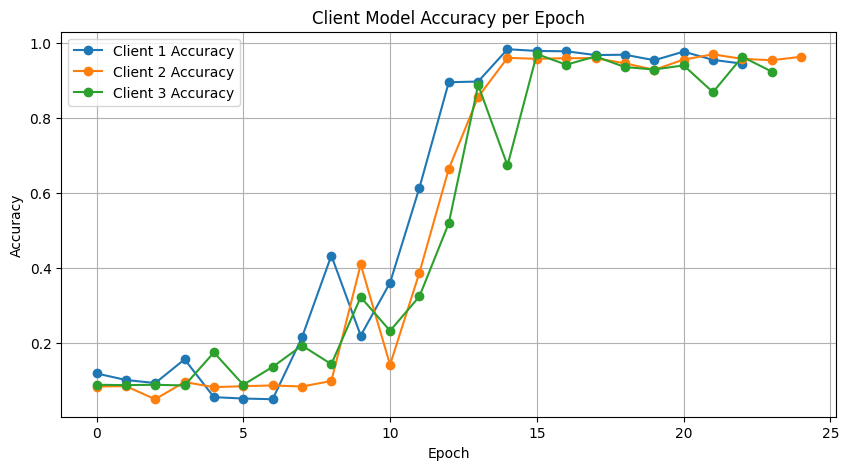

In [18]:
# Plot accuracy graph for each client
plt.figure(figsize=(10, 5))
for client in range(len(client_accuracies)):
    plt.plot(client_accuracies[client], marker='o', label=f'Client {client + 1} Accuracy')
plt.title('Client Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

131/131 [==============================] - 13s 99ms/step


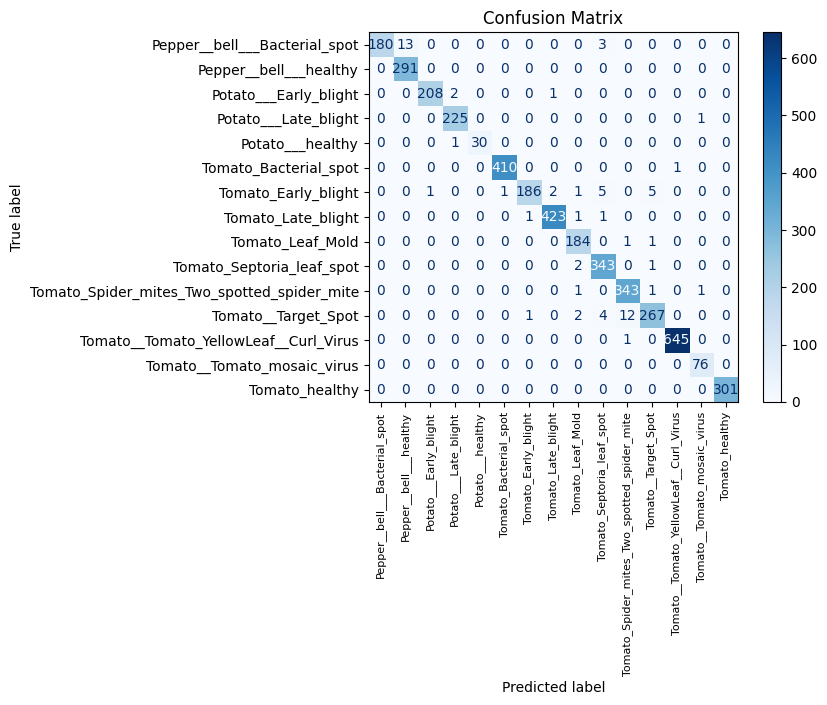

Final Accuracy: 97.87081480026245
Final F1-score: 0.9836276421015993
Final Precision: 0.9840060858384451
Final Recall: 0.9837320574162679


In [19]:
scores = global_model.evaluate(generators_test)
final_accuracy = scores[1]

# Calculate predictions
predictions = global_model.predict(generators_test)
y_true = generators_test.classes
y_pred = np.argmax(predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(generators_test.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(fontsize=8, rotation=90)

plt.show()

# Calculate precision, recall, and F1-score
final_precision = precision_score(y_true, y_pred, average='weighted')
final_recall = recall_score(y_true, y_pred, average='weighted')
final_f1 = f1_score(y_true, y_pred, average='weighted')

# Print final results
print("Final Accuracy:", final_accuracy * 100)
print("Final F1-score:", final_f1)
print("Final Precision:", final_precision)
print("Final Recall:", final_recall)

In [14]:
predict = global_model.predict_generator(generators_test)

C:\Users\USER\AppData\Local\Temp\ipykernel_8636\3248106952.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = global_model.predict_generator(generators_test)


In [15]:
np.argmax(predict,axis=1)

array([ 0,  0,  0, ..., 14, 14, 14], dtype=int64)

In [16]:
generators_train_client[0].classes

array([ 0,  0,  0, ..., 14, 14, 14])

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Train the model (your training loop code here)

# Evaluate global model on the test data
scores = global_model.evaluate_generator(generators_test)
final_accuracy = scores[1]

# Calculate predictions
predictions = global_model.predict_generator(generators_test)
y_true = generators_test.classes
y_pred = np.argmax(predictions, axis=1)

# Calculate precision, recall, and F1-score
final_precision = precision_score(y_true, y_pred, average='weighted')
final_recall = recall_score(y_true, y_pred, average='weighted')
final_f1 = f1_score(y_true, y_pred, average='weighted')

# Print final results
print("Final Accuracy:", final_accuracy * 100)
print("Final F1-score:", final_f1)
print("Final Precision:", final_precision)
print("Final Recall:", final_recall)


C:\Users\USER\AppData\Local\Temp\ipykernel_8636\84232528.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = global_model.evaluate_generator(generators_test)
C:\Users\USER\AppData\Local\Temp\ipykernel_8636\84232528.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = global_model.predict_generator(generators_test)


Final Accuracy: 98.20573925971985
Final F1-score: 0.9833843990385223
Final Precision: 0.9837798889097339
Final Recall: 0.9834928229665072
